# X-rays in trigger 1

## Authors: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- Run 6817. January 2019. Low background run, closed castle, sources, 7.7 kV


In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Wed Jan 30 11:43:12 2019


In [2]:
run_number  = 6817
file_range  = 0, 10000

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
tags        = 'v0.9.9_20190111_krth'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"
write_filtered_dst = True

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [6]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [7]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.analysis_functions import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [8]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [9]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [10]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core import fit_functions_ic as fitf
from krcal.core.histo_functions import profile1d

### Input/output 

In [11]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6817/kdst_0000_6817_trigger1_v0.9.9_20190111_krth.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6817/kdst_9999_6817_trigger1_v0.9.9_20190111_krth.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6817_trigger1_0000_9999.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6817_trigger1_0000_9999.h5


In [12]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

/Users/jjgomezcadenas/Projects/IC/invisible_cities/io/dst_io.py:21: UserWarning:  does not exist: file = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6817/kdst_5824_6817_trigger1_v0.9.9_20190111_krth.h5 
  warnings.warn(f' does not exist: file = {filename} ', UserWarning)


In [13]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 3454543 
Total number of events: 2039174


In [14]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [15]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 3454543


In [65]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (1, 25)
s2e_range = (1000, 15000)
s2q_range = (200, 800)
s2w_range = (4, 15)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

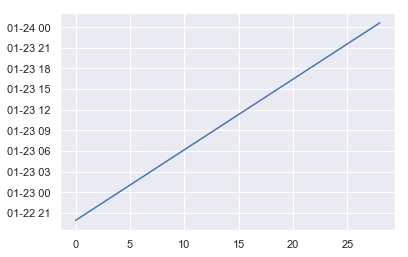

In [58]:
plt.plot(krTimes.timeStamps)

### S1/S2

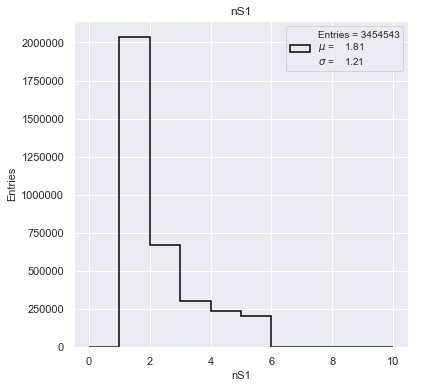

In [16]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [17]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.5899061033543366


#### Fraction of events with 1 S1 is 0.5. For Krypton select events with 1 S1

### Select events with 1 S1

In [66]:
dst1s1 = dst_full[dst_full.nS1==1]

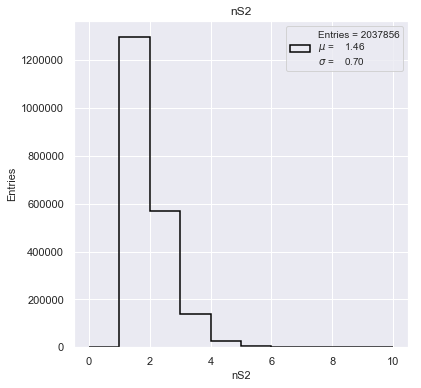

In [67]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with only 1 S2

In [68]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.6370607147904465


### Select events with 1 S2

In [69]:
dst    = dst1s1[dst1s1.nS2==1]

In [70]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1298238: selection eff = 0.3758060038621606 


### S1 and S2 distributions

In [71]:
s1d = s1d_from_dst(dst)

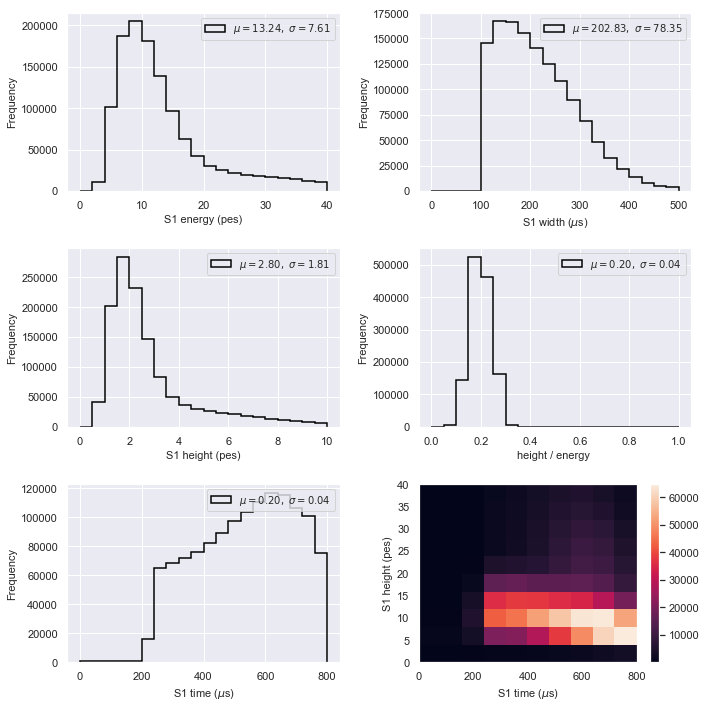

In [72]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### S1 time (Z) distribution is biased towards low z

### Selection in S1 energy

In [73]:
dst_s1e    = dst[in_range(dst.S1e, *s1e_range)] 
dst = dst_s1e

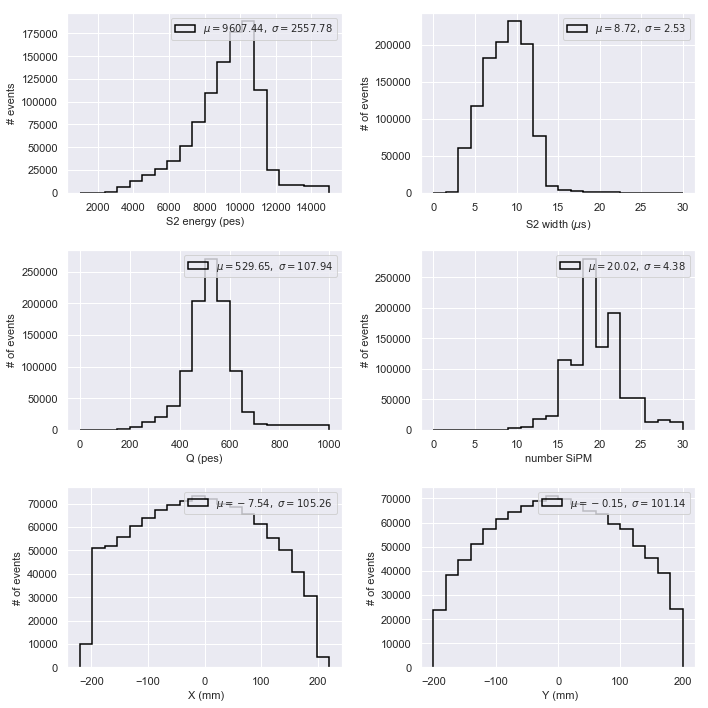

In [74]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

#### Feature of the data: 
1. Low tail in S2, indicating many events with less energy than that of Krypton. One expects X-rays froms sources.
2. Number of SiPMs has a peculiar distribution that indicates several possible distributions.
3. The X distribution shows an excess of events at negative X (left side of the detector) while the Y distribution follows the expected pattern. 

### Selection in S2 energy and width

In [77]:
dst_s2e    = dst[in_range(dst.S2e, *s2e_range)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, *s2w_range)]
dst = dst_s2w

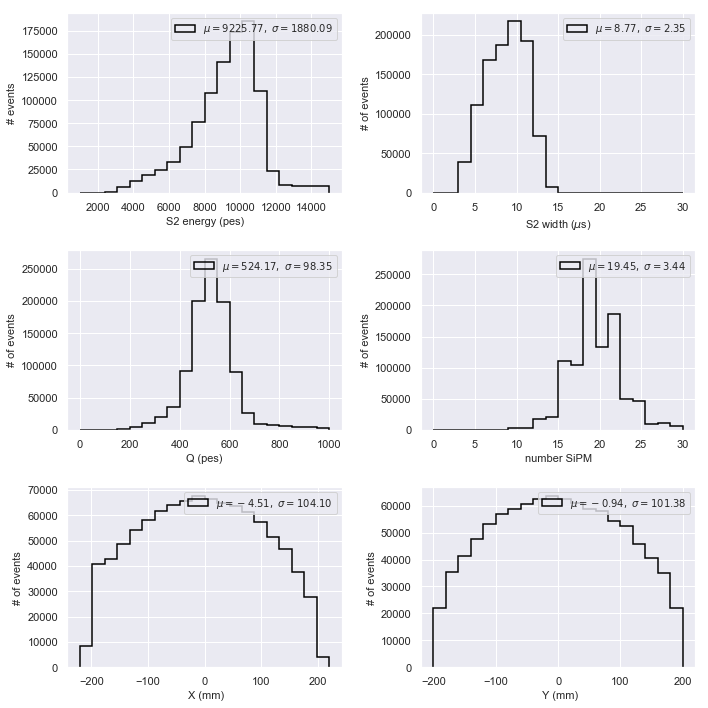

In [78]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Require that the number of SiPM is larger than 15 and charge is between 200-800 in the SiPM plane

In [79]:
Nsipm_min = 15
s2q_range =(200, 800)
dst_sipm  = dst[dst.Nsipm >Nsipm_min] 
dst_s2q   = dst_sipm[in_range(dst_sipm.S2q, *s2q_range)]
dst       = dst_s2q

### Plot s2 distributions

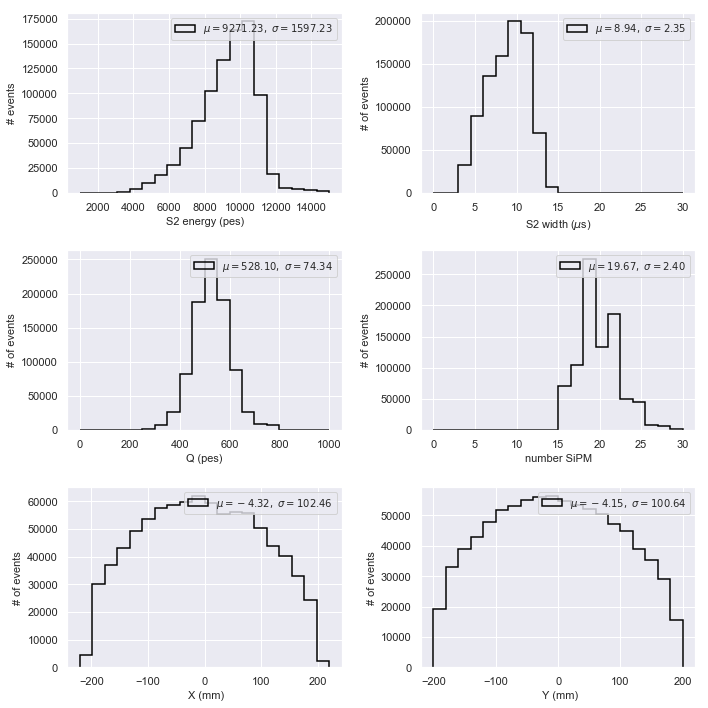

In [80]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

#### NB: The cuts on the SiPM plane have reduce the asymmetry on X, indicating that they eliminate X--rays

### Plot S1 distributions

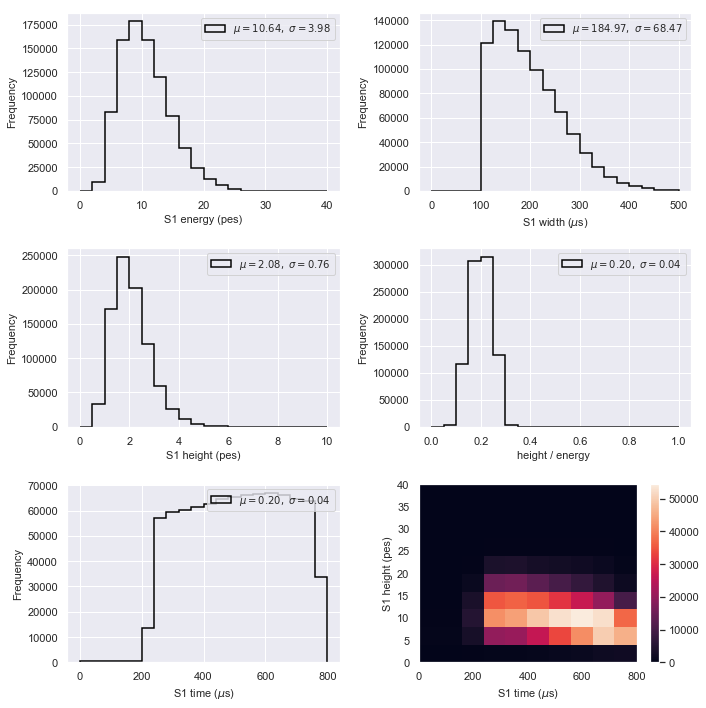

In [81]:
s1d = s1d_from_dst(dst, range_s1e = s1e_range)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

#### NB: The infamous Z distribution (S1 time) has become much flatter, suggesting that the reason for bias were the X rays that have been eliminated. 

## Investigate events with less than 15 SiPms

In [84]:
dst = dst_s2w
dst_sipm  = dst[dst.Nsipm < Nsipm_min] 
dst_s2q   = dst_sipm[in_range(dst_sipm.S2q, *s2q_range)]
dst       = dst_s2q

### S1

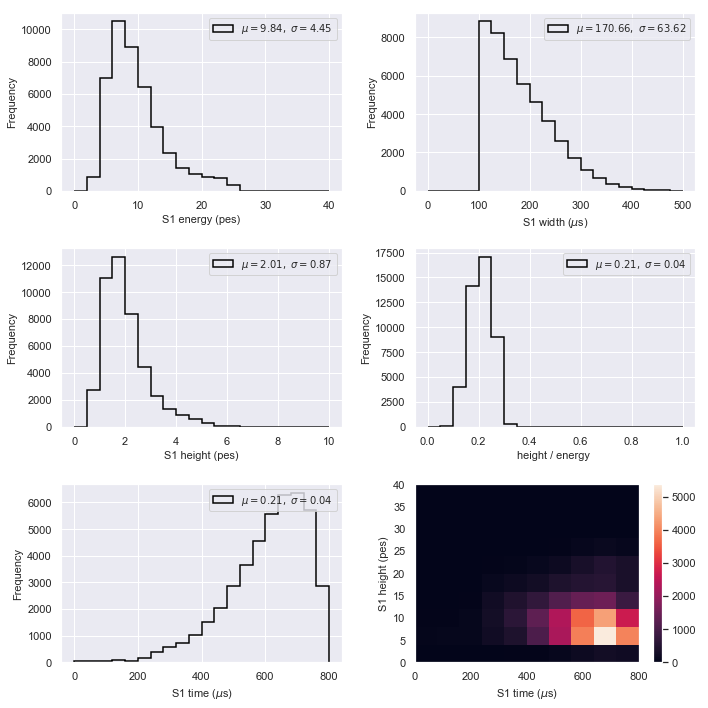

In [85]:
s1d = s1d_from_dst(dst, range_s1e = s1e_range)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### S2

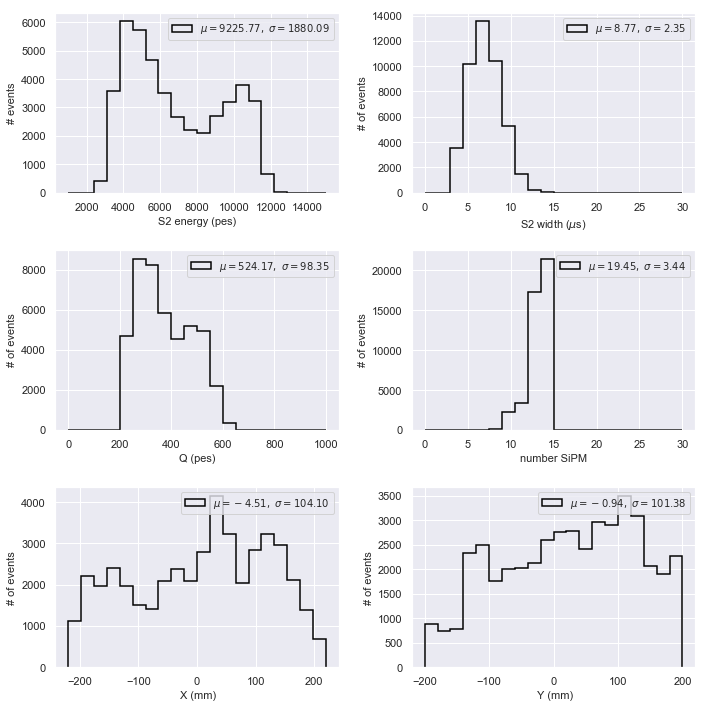

In [86]:
s2d = s2d_from_dst(dst_s2e)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Features of events:

1. A large fraction of the events are background. The distribution looks like a continuous of low energy x-rays
2. The S2 width and the number of SiPMs indicate events at low Z
4. S1 peaks at very low Z, but is thas a long tail.  

### Time differences in seconds

In [89]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [90]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

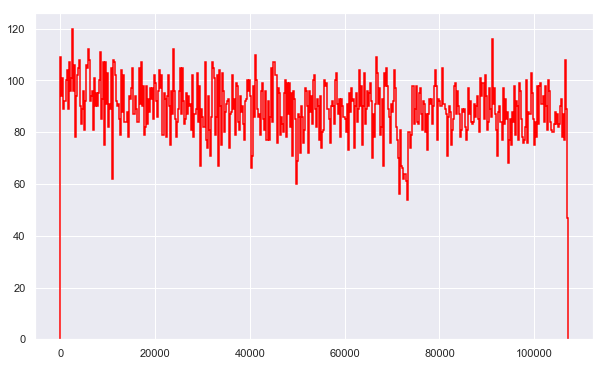

In [91]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Control distributions

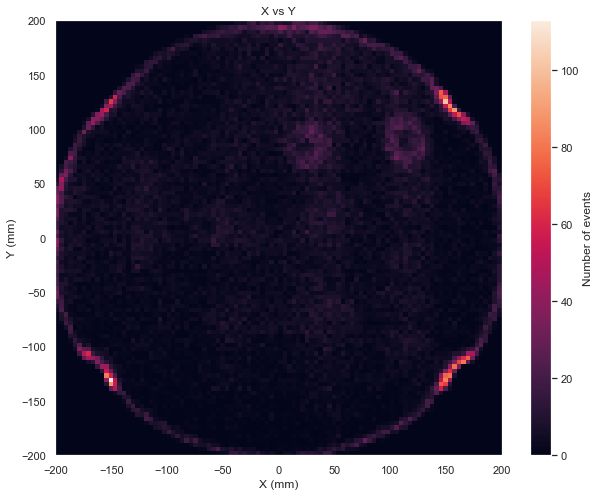

In [92]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

#### Bulk of events at large R: It has two populations. Krypton events are concentrated in the "lunar crates" corresponding to areas with dead SiPMs (thus they have less sipms touched per event than krypton events happening elsewhere). Background events are concentrated at large R, in specific bright spots that suggest "hot spots" (e.g, grid support?)

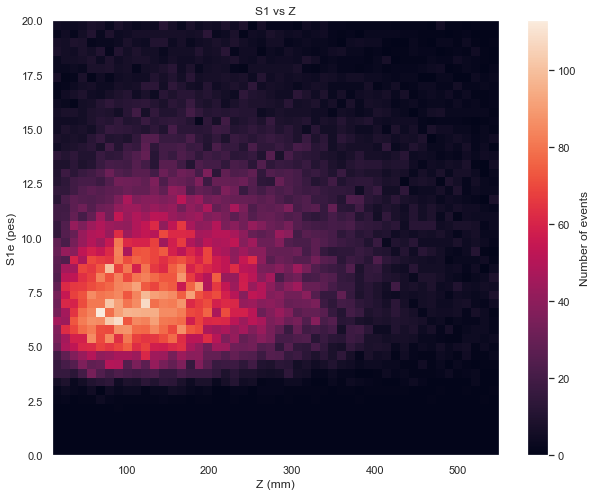

In [93]:
nevt = h2d(dst.Z, dst.S1e, krNbins.Z, krNbins.S1e, krRanges.Z, (0,20), 
           pltLabels=PlotLabels(x='Z (mm)', y='S1e (pes)', title='S1 vs Z'),
           profile=False,
           figsize=(10,8))

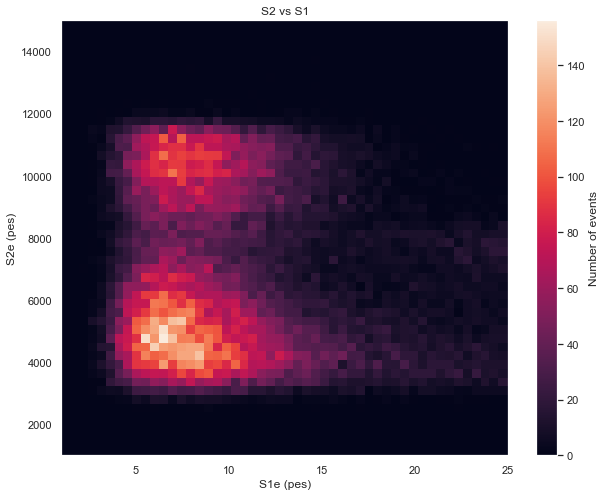

In [94]:
nevt = h2d(dst.S1e, dst.S2e, krNbins.S1e, krNbins.S2e, krRanges.S1e, krRanges.S2e, 
           pltLabels=PlotLabels(x='S1e (pes)', y='S2e (pes)', title='S2 vs S1'),
           profile=False,
           figsize=(10,8))

### Two populations: Krypton and low energy

## Radial dependence

### R < 100

In [96]:
dst_R     = dst[dst.R < 100]

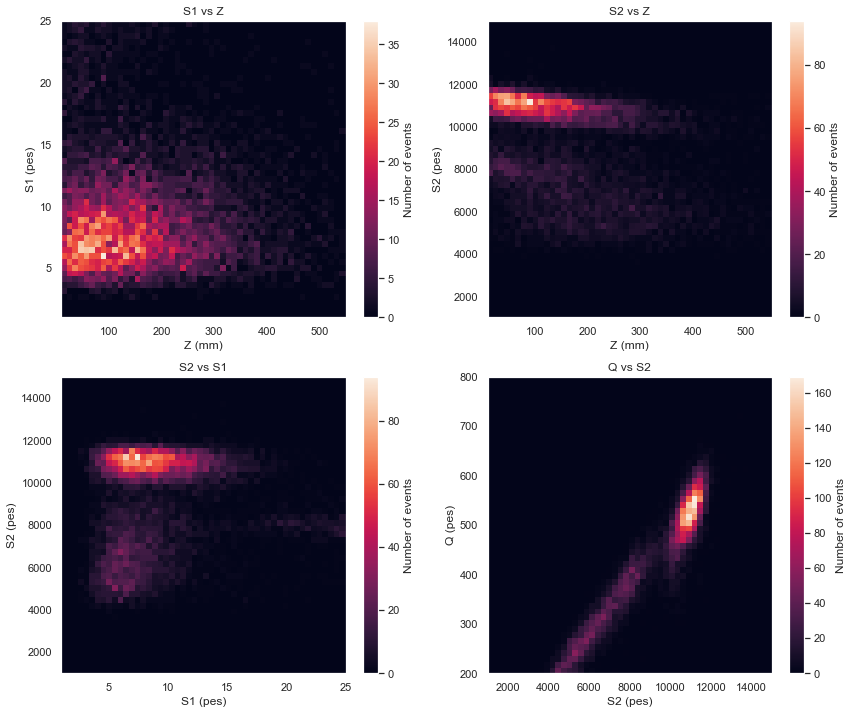

In [97]:
plot_energy_distributions(dst_R, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

#### Bulk of the events at low R are krypton, but background events clearly present

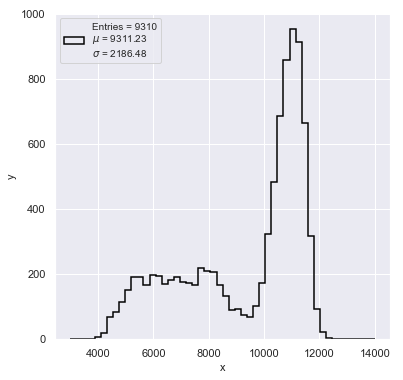

In [98]:
(_) = h1d(dst_R.S2e, bins = 50, range =(3000,14000), legendloc='upper left')

#### No peak for background events, who appear to be a continuous

### 100 < R < 220

In [99]:
dst_Ro     = dst[in_range(dst.R, 100, 220)]

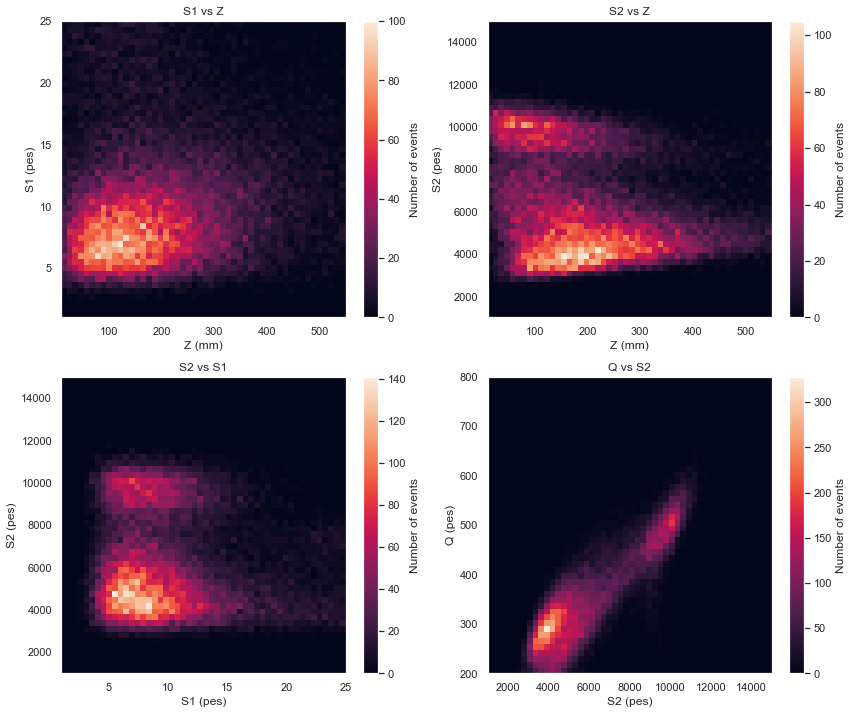

In [100]:
plot_energy_distributions(dst_Ro, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

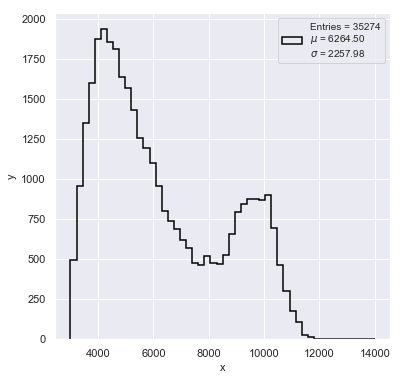

In [101]:
(_) = h1d(dst_Ro.S2e, bins = 50, range =(3000,14000), legendloc='upper right')

#### As we move towards the outer detector more background appears

### 160 < R < 220

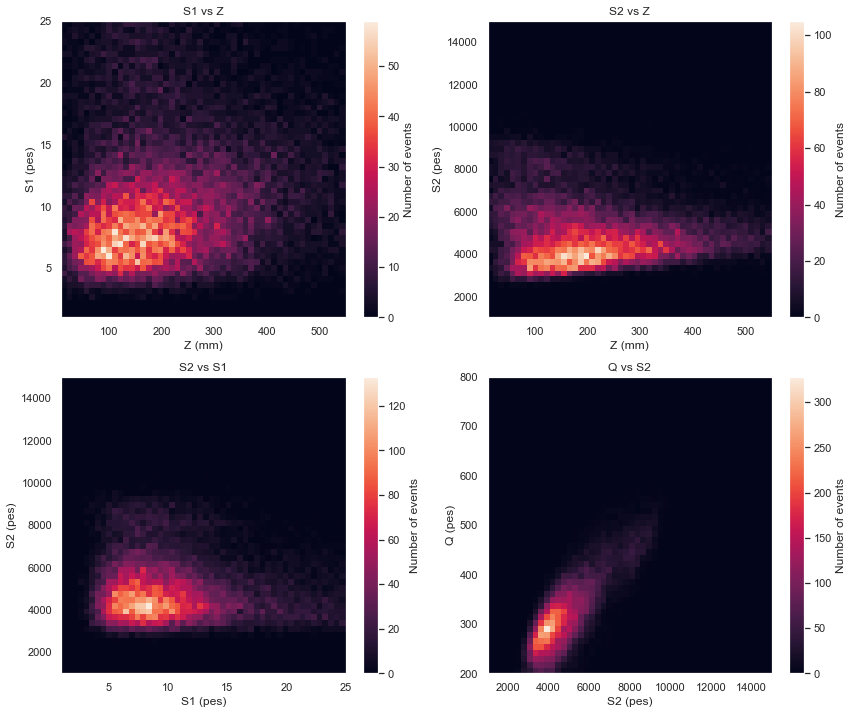

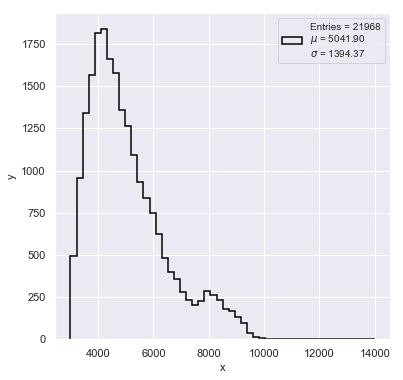

In [102]:
dst_Ro     = dst[in_range(dst.R, 160, 220)]
plot_energy_distributions(dst_Ro, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))
(_) = h1d(dst_Ro.S2e, bins = 50, range =(3000,14000), legendloc='upper right')

#### Background becomes dominant for R > 160

### 180 < R < 220

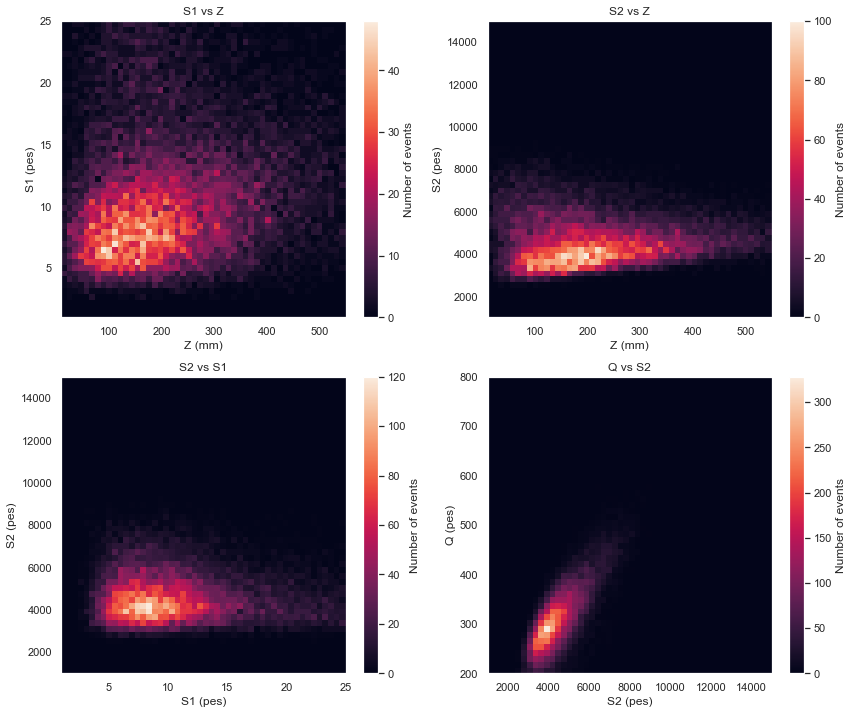

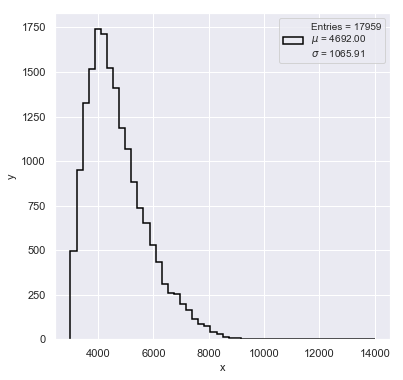

In [103]:
dst_Ro     = dst[in_range(dst.R, 180, 220)]
plot_energy_distributions(dst_Ro, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))
(_) = h1d(dst_Ro.S2e, bins = 50, range =(3000,14000), legendloc='upper right')

#### At large R (R > 160) only background events. 

## Apply bootstrap corrections.

- One can correct S2e and S2q by geometrical corrections using an existing map (a bootstrap map). This has the effect to reduce the geometrical dependence on both distributions, permitting an additional filtering

In [105]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [106]:
kre = kr_event(dst)

In [107]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(kre.X, kre.Y, None, kre.T, kre.S2e, kre.S2q)

In [109]:
kge = kr_event(dst, DT, E, Q)

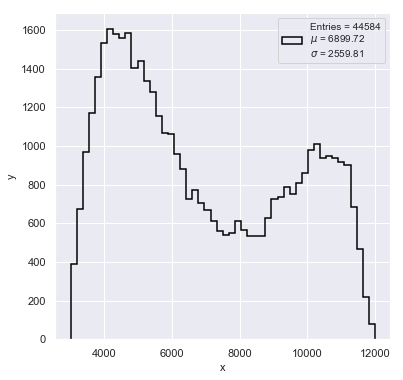

In [111]:
(_) = h1d(kge.S2e, bins = 50, range =(3000,12000))

#### Before geometrical corrections. No clear peaks in the data.

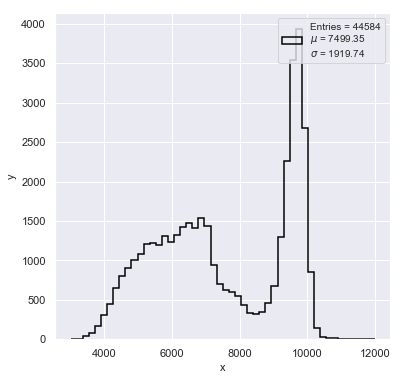

In [110]:
(_) = h1d(kge.E, bins = 50, range =(3000,12000))

#### Applying goemetrical corrections it appears that only one peak (Krypton) is present and the rest is low background.

### Plot of E and Q corrected vs Z shows much less spread (XY corrections applied only remaining LT corrections)

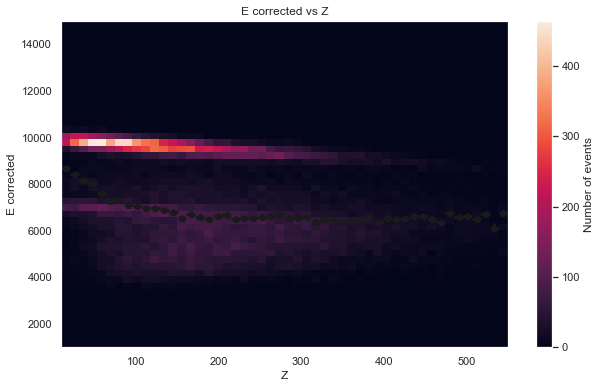

In [112]:
nevt = h2d(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z'),
           profile=True,
           figsize=(10,6))

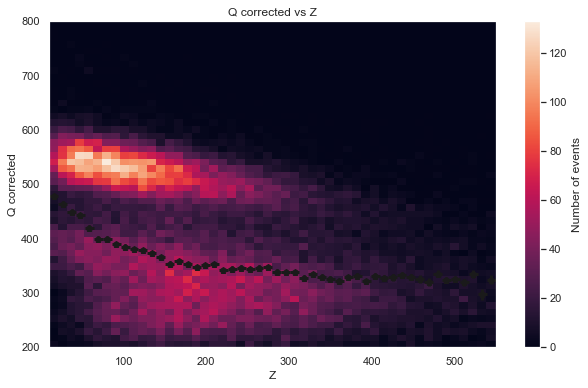

In [113]:
nevt = h2d(dst.Z, Q, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z'),
           profile=True,
           figsize=(10,6))

## Events with more than 15 SiPMs

In [125]:
dst = dst_s2w
dst_sipm  = dst[dst.Nsipm > Nsipm_min] 
dst_s2q   = dst_sipm[in_range(dst_sipm.S2q, *s2q_range)]
dst       = dst_s2q

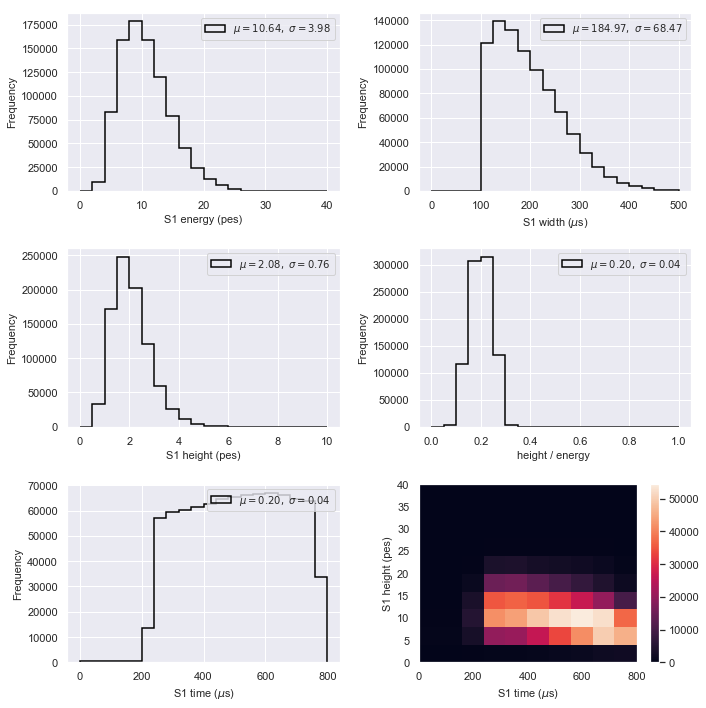

In [126]:
s1d = s1d_from_dst(dst, range_s1e = s1e_range)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

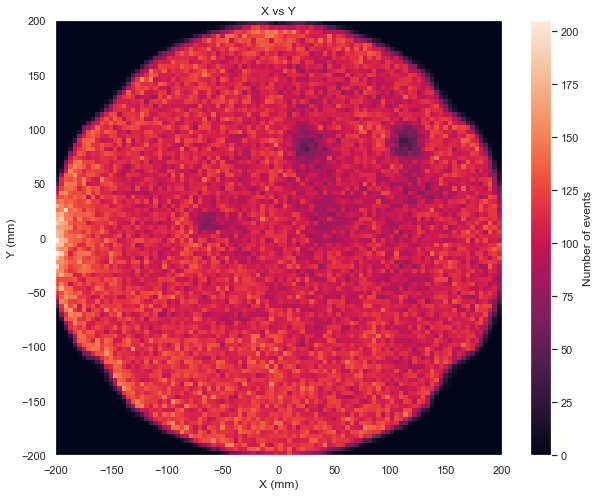

In [127]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

#### Notice that the "lunar crates" become "dark spots", since we are biasing against them

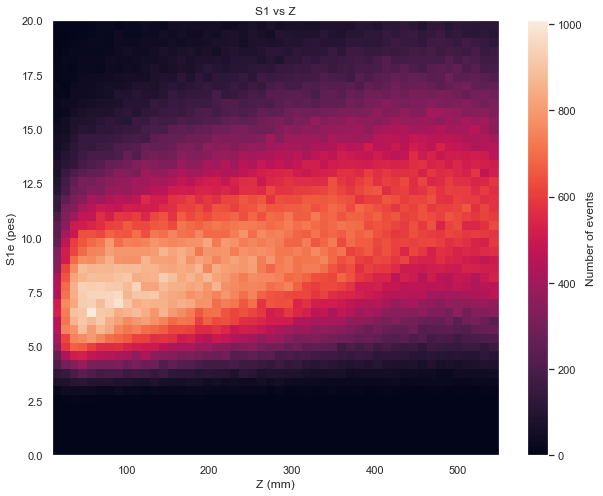

In [128]:
nevt = h2d(dst.Z, dst.S1e, krNbins.Z, krNbins.S1e, krRanges.Z, (0,20), 
           pltLabels=PlotLabels(x='Z (mm)', y='S1e (pes)', title='S1 vs Z'),
           profile=False,
           figsize=(10,8))

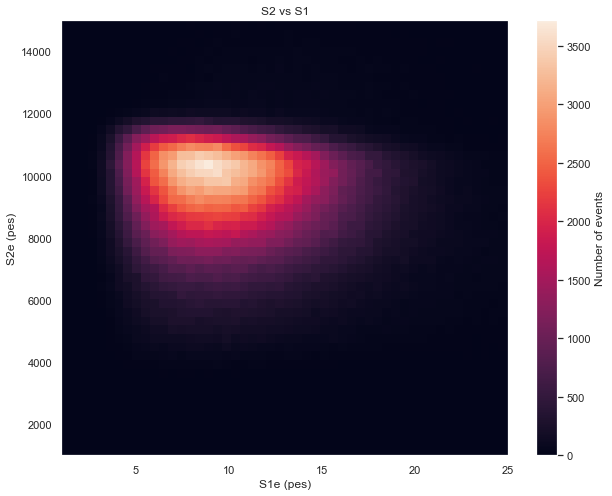

In [129]:
nevt = h2d(dst.S1e, dst.S2e, krNbins.S1e, krNbins.S2e, krRanges.S1e, krRanges.S2e, 
           pltLabels=PlotLabels(x='S1e (pes)', y='S2e (pes)', title='S2 vs S1'),
           profile=False,
           figsize=(10,8))

In [130]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [131]:
kre = kr_event(dst)

In [132]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(kre.X, kre.Y, None, kre.T, kre.S2e, kre.S2q)

In [133]:
kge = kr_event(dst, DT, E, Q)

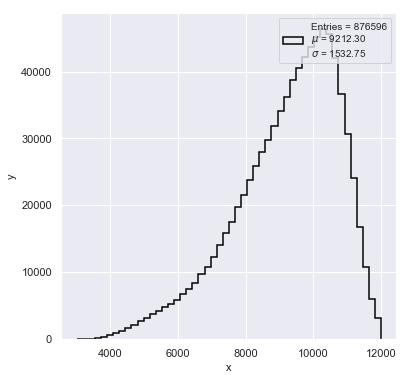

In [134]:
(_) = h1d(kge.S2e, bins = 50, range =(3000,12000))

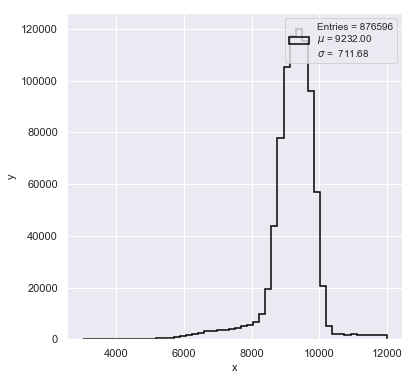

In [135]:
(_) = h1d(kge.E, bins = 50, range =(3000,12000))

#### One can see that events with more than 15 SiPMs  still have a small tail of background events

### Filter

In [139]:
range_krs2 = (8e+3,12e+3)

In [140]:
sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z, E,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 25,
                                                 nbins_e = 25,
                                                 nsigma  = 2.5)

/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


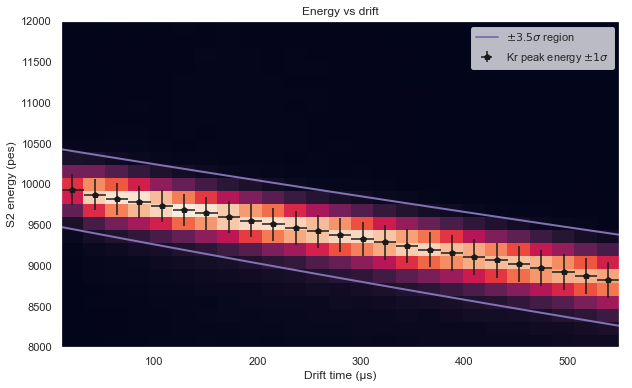

In [141]:
plot_selection_in_band(fpl, fph, hp, pp)

In [142]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 748431 (85.4 %)


'Total number of selected candidates Kr band: 748431 (85.4 %)'

In [143]:
kges = kr_event(dst, DT, E, Q, sel_mask=sel_krband)

### Energy before and after filter

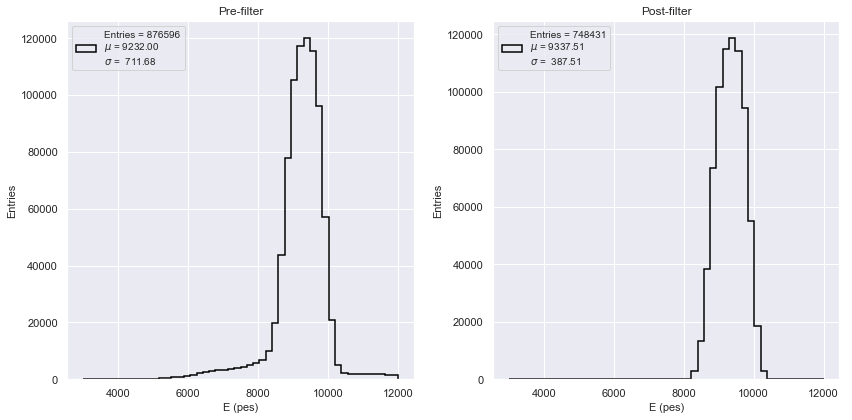

In [144]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(kge.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kges.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

### Tail has dissappeared! 

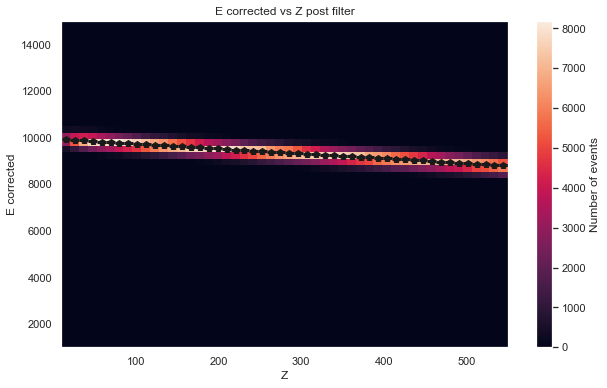

In [145]:
nevt = h2d(kges.Z, kges.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z post filter'),
           profile=True,
           figsize=(10,6))

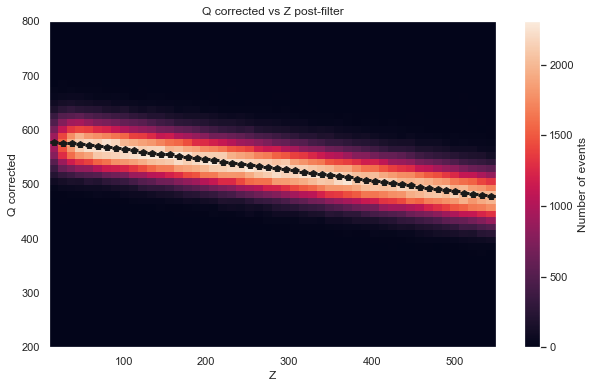

In [146]:
nevt = h2d(kges.Z, kges.Q, krNbins.Z, krNbins.S2q, krRanges.Z, krRanges.S2q, 
           pltLabels=PlotLabels(x='Z', y='Q corrected', title='Q corrected vs Z post-filter'),
           profile=True,
           figsize=(10,6))

#### Notice how the filter cleans up the energy distributions. 

In [147]:
dsts = dst[sel_krband]

warning, empty slice of x = [734400. 490350. 598325. ... 703125. 678325. 231100.] in range = (0, 600)
returning mean and std of x = [734400. 490350. 598325. ... 703125. 678325. 231100.]


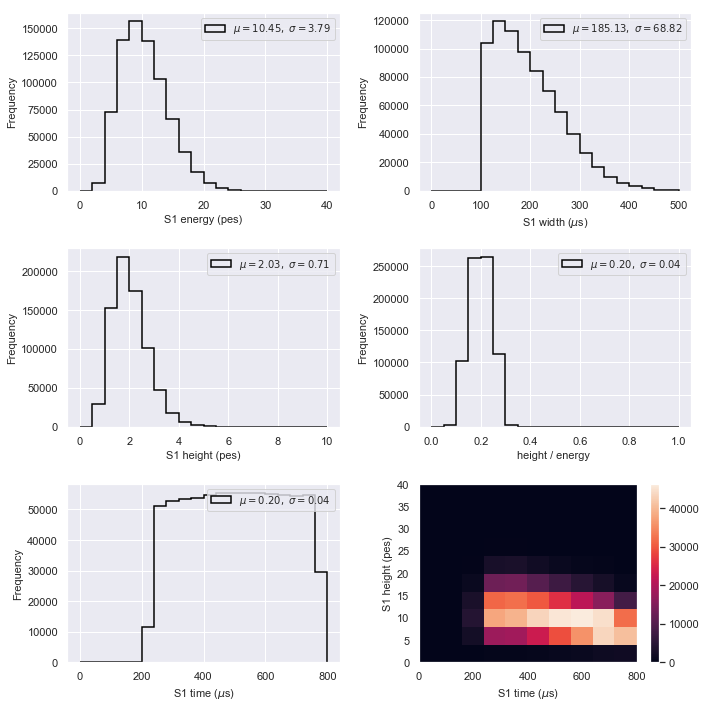

In [148]:
s1d = s1d_from_dst(dsts, range_s1e = s1e_range)
plot_s1histos(dsts,  s1d, bins=20, figsize=(10,10))

### Events used for maps show a flat Z distribution

### X vs Y again

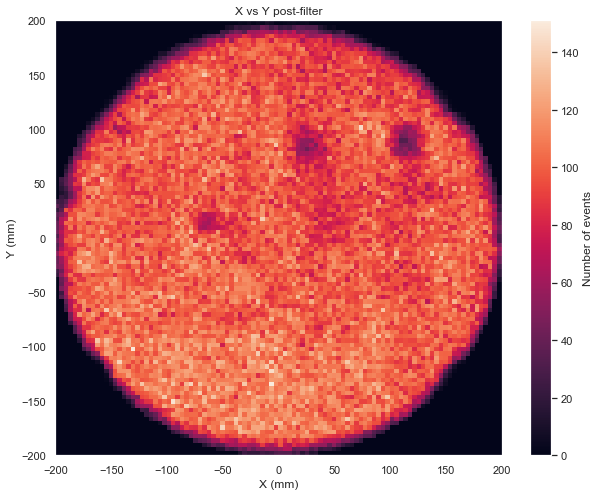

In [149]:
nevt = h2d(dsts.X, dsts.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y post-filter'),
           profile=False,
           figsize=(10,8))

## Finally, relax the cut on NSiPM, but keep filter in band, to supress most of the background

In [186]:
Nsipm_min = 10
dst_sipm  = dst[dst.Nsipm > Nsipm_min] 
dst       = dst_s2q

In [187]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [188]:
kre = kr_event(dst)

In [189]:
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(kre.X, kre.Y, None, kre.T, kre.S2e, kre.S2q)

In [190]:
kge = kr_event(dst, DT, E, Q)

In [191]:
sel_krband, fpl, fph, hp, pp = selection_in_band(kre.Z, E,
                                                 range_z = krRanges.Z,
                                                 range_e = range_krs2,
                                                 nbins_z = 25,
                                                 nbins_e = 25,
                                                 nsigma  = 2.5)

/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


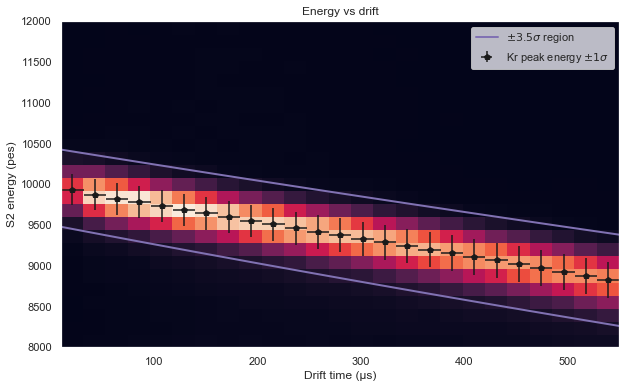

In [192]:
plot_selection_in_band(fpl, fph, hp, pp)

In [193]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 791053 (82.5 %)


'Total number of selected candidates Kr band: 791053 (82.5 %)'

In [194]:
kges = kr_event(dst, DT, E, Q, sel_mask=sel_krband)

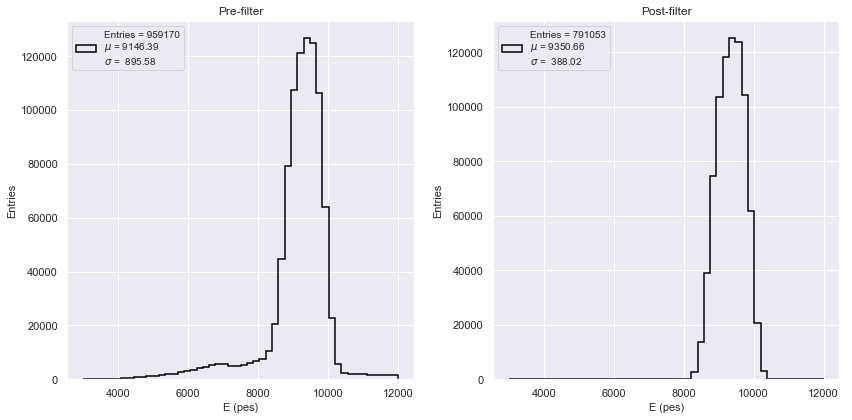

In [195]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(kge.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kges.E,  bins = 50, range =(3000,12000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

In [196]:
dsts = dst[sel_krband]

warning, empty slice of x = [734400. 490350. 598325. ... 703125. 678325. 231100.] in range = (0, 600)
returning mean and std of x = [734400. 490350. 598325. ... 703125. 678325. 231100.]


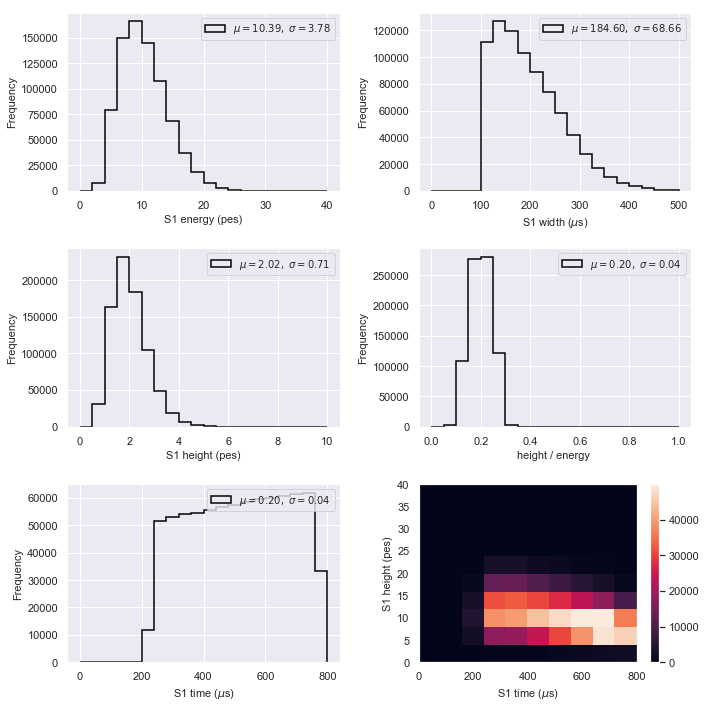

In [197]:
s1d = s1d_from_dst(dsts, range_s1e = s1e_range)
plot_s1histos(dsts,  s1d, bins=20, figsize=(10,10))

### Events passing the selection band are clearly Kryptons. The Z distribution is still a bit biased, showing that there is an excess at low z. This excess on low z is at high R. 

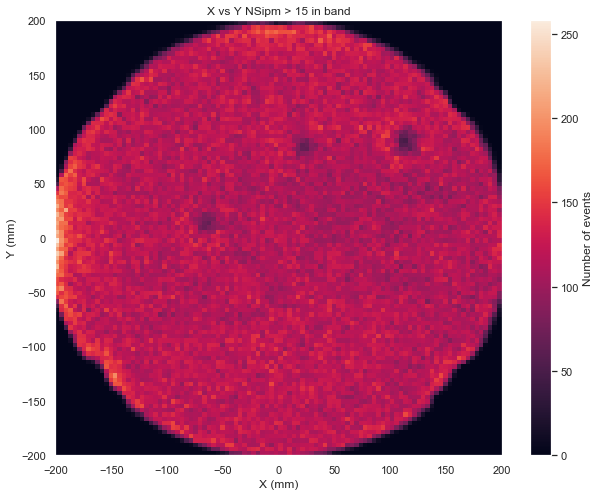

In [198]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y NSipm > 15 in band'),
           profile=False,
           figsize=(10,8))

### Dark spots in XY are less dark, since the cut on SiPMs which tend to supress events there has been relaxed

### We impose now a fiducial cut (R < 180)

In [199]:
dst = dsts[dsts.R<RFID]

warning, empty slice of x = [734400. 490350. 598325. ... 347050. 678325. 231100.] in range = (0, 600)
returning mean and std of x = [734400. 490350. 598325. ... 347050. 678325. 231100.]


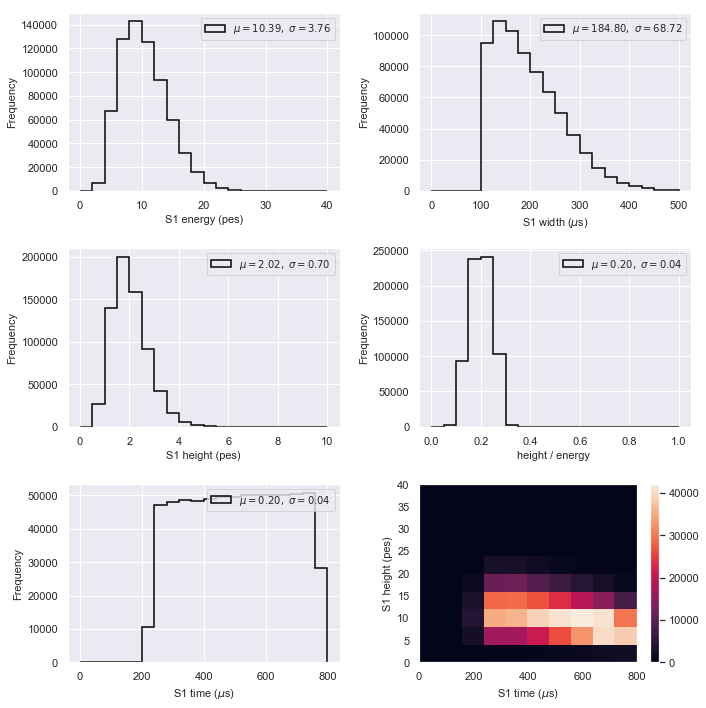

In [200]:
s1d = s1d_from_dst(dst, range_s1e = s1e_range)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### Bias dissappears, showing that excess of krypton events at low Z are also at high R.

### This selection:
1. Uses filter band and fiducial cut at R < 180
2. Relaxes the cut on Nsipm (Nsipm > 10), and thus avois supressing events in "dark spots".
3. Selects events flat on Z (no bias). 

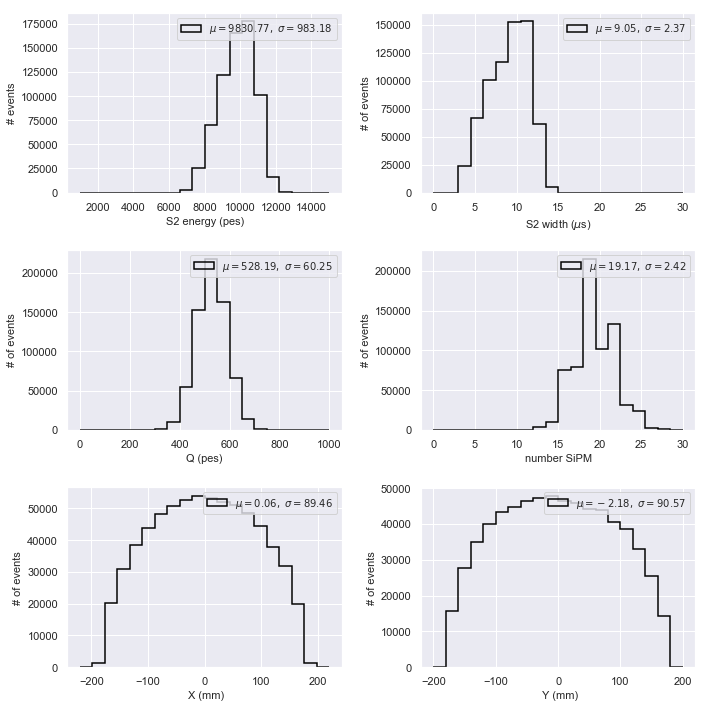

In [201]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

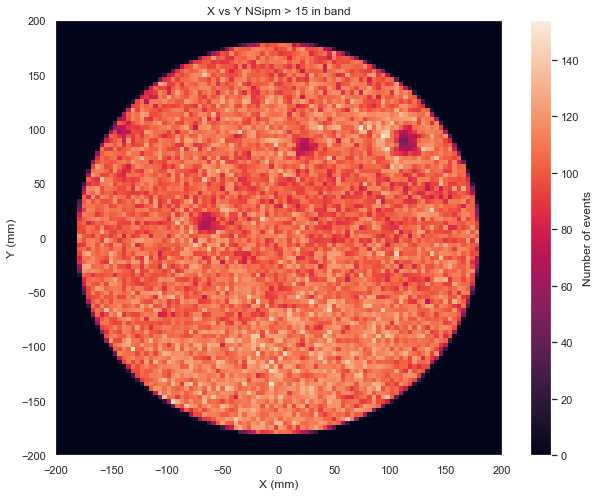

In [202]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y NSipm > 15 in band'),
           profile=False,
           figsize=(10,8))

## Select now events in the band selection with NSipm < 15

In [203]:
Nsipm_min = 15
dst_sipm  = dsts[dsts.Nsipm < Nsipm_min] 
dst       = dst_sipm

In [204]:
len(dst)

15289

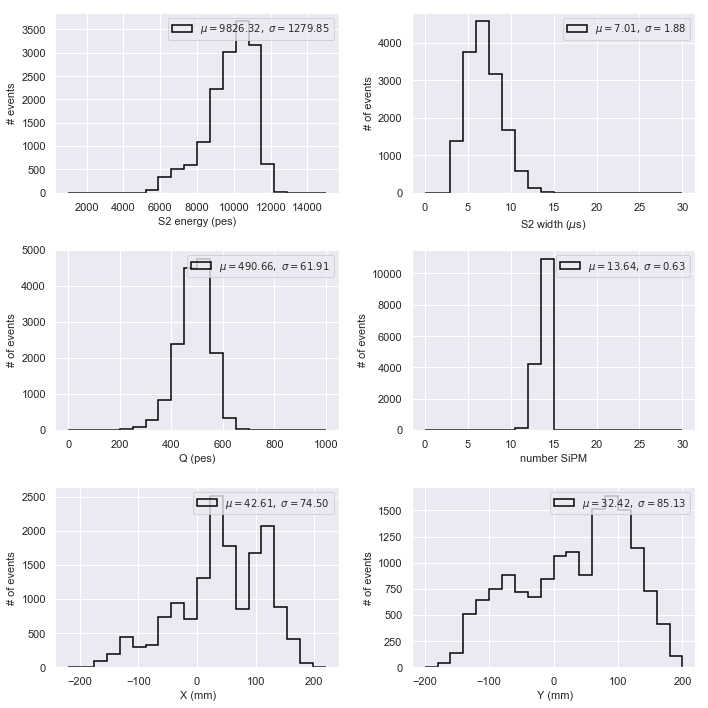

In [205]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

warning, empty slice of x = [351500. 584975. 632800. ... 662050. 650625. 568375.] in range = (0, 600)
returning mean and std of x = [351500. 584975. 632800. ... 662050. 650625. 568375.]


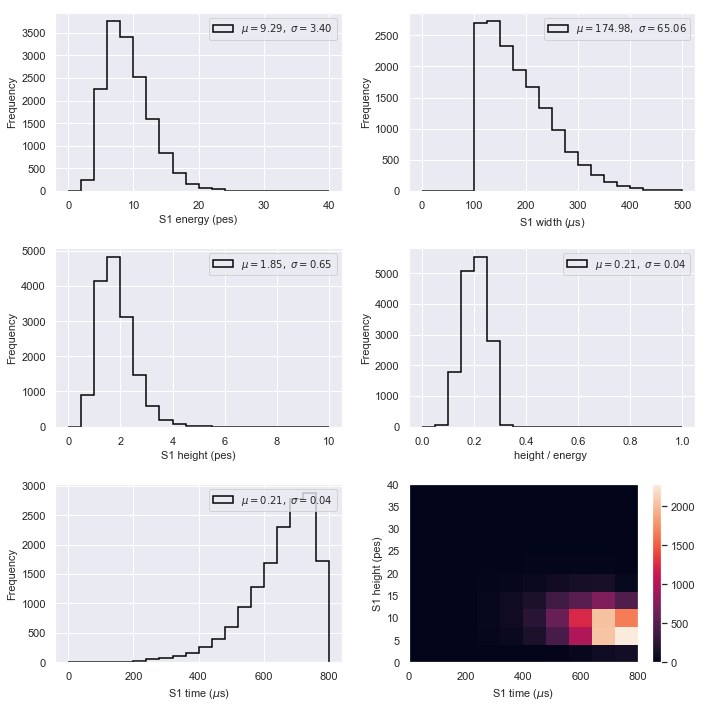

In [206]:
s1d = s1d_from_dst(dst, range_s1e = s1e_range)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

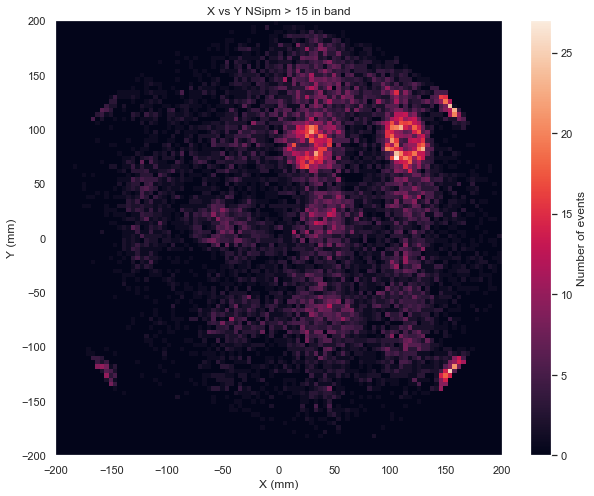

In [207]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y NSipm > 15 in band'),
           profile=False,
           figsize=(10,8))

#### The bulk of these events are kryptons. They concentrate in the "dark spots" which become brighter now (spots with dead SiPMs will result in true Kryptons having less touched SiPMs). There are also funny bright spots at large R. Those events are probably background. 

In [208]:
dstf = dst[dst.R < RFID]

In [209]:
len(dstf)

14033

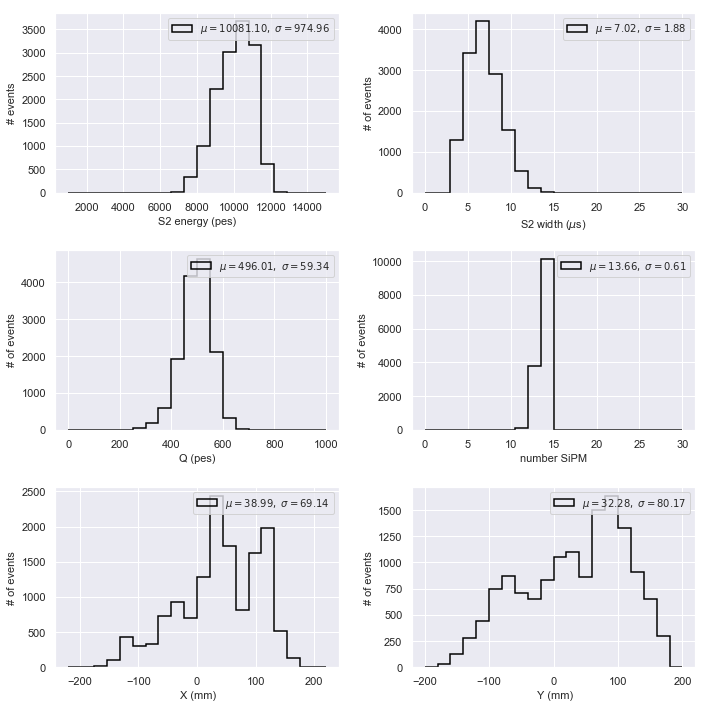

In [210]:
s2d = s2d_from_dst(dstf)
plot_s2histos(dstf, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

warning, empty slice of x = [351500. 632800. 556325. ... 662050. 650625. 568375.] in range = (0, 600)
returning mean and std of x = [351500. 632800. 556325. ... 662050. 650625. 568375.]


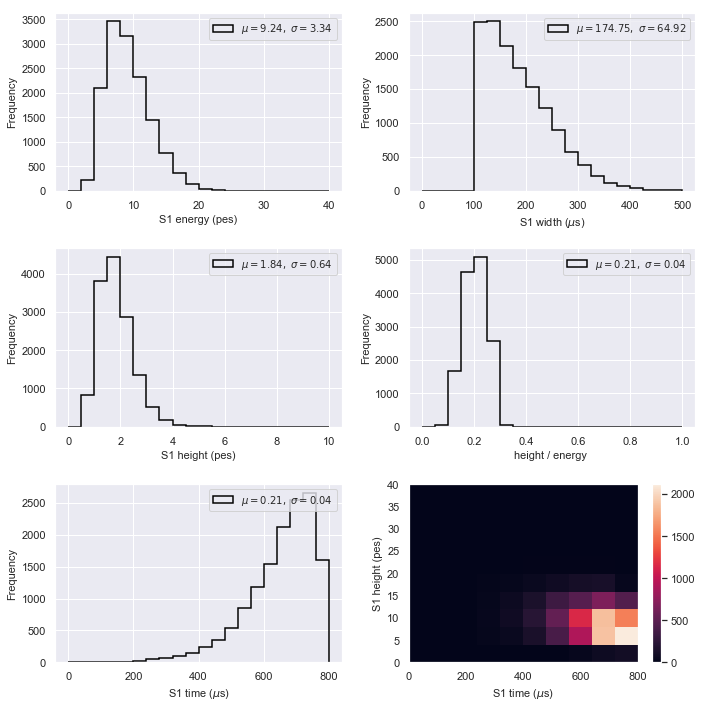

In [211]:
s1d = s1d_from_dst(dstf, range_s1e = s1e_range)
plot_s1histos(dstf,  s1d, bins=20, figsize=(10,10))

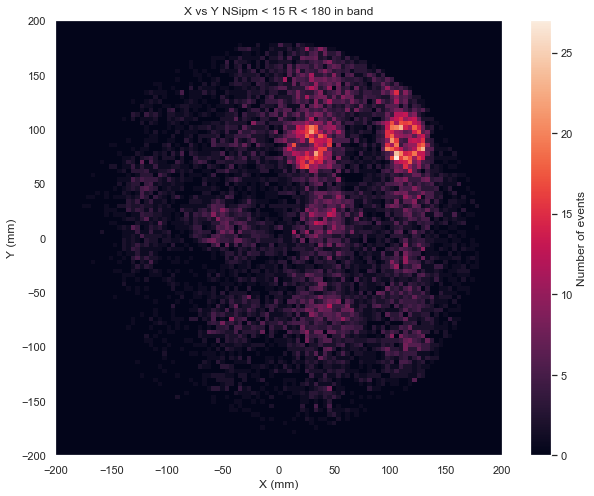

In [212]:
nevt = h2d(dstf.X, dstf.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y NSipm < 15 R < 180 in band'),
           profile=False,
           figsize=(10,8))

### The bulk of these events correspond to areas where we have less SiPM. Setting a cut on NSiPM results on effectively vetoeing these regions. It follows that one wants to enforce the band selection and eventually the fiducial cut, but relax the cut on NSiPMs.  

## Outlook:

1. Low background present in trigger 1 data. Features of the background: a) low z; b) large radius; it may be produced by radioactive stuff at the anode; It is produced at large R: Grid supports?
2. Background does not have a clear feature (no peaks present). 
3. Presence of background contributes to the aparent bias in Z position when plotting unselected events. 
4. Supressing background with a band filter cleans up all low energy background.
5. A cut  R < 180 gets rid of excess of events at low Z and high R. This cut is preferable to the cut Nsipm > 15 aince the latest "blinds" the dark spots. 

## End of NB